In [0]:
!pip install transformers
from google.colab import drive
import os
drive.mount('/content/drive', force_remount=True)
os.chdir('drive/My Drive/Camembert')

In [0]:
from transformers import AutoTokenizer, CamembertModel
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def load_camembert():
  """Loads CamemBERT model and associated tokenizer"""
  device = torch.device("cuda")
  tokenizer = AutoTokenizer.from_pretrained("camembert-base")
  model = CamembertModel.from_pretrained("camembert-base")
  model.to(device)
  return tokenizer, model, device

def sentence_embedding(tokenizer, model, sentence, device):
  """Returns a 768 sized raw embedding of an input sentence (np array), based 
  on the embedding of the CLS token"""
  input_ids = torch.tensor([tokenizer.encode(sentence, add_special_tokens=True, max_length=500)]).to(device) 
  assert input_ids[0][0] == 5 # CLS token id
  embeddings = model(input_ids)[0]
  return embeddings[0][0].cpu().detach().numpy()

def text_embedding(tokenizer, model, sentences, device):
  """Returns a 768 sized raw embedding of an input text in the form of a list 
  of sentences, as the average of their embeddings"""
  embeddings = np.zeros(768)
  for sentence in sentences:
    embeddings += sentence_embedding(tokenizer, model, sentence, device)
  return embeddings/max(len(sentences),1)

def visualize_doc_embeddings(my_doc_embs,my_labels):
  """Plots and save a TSNE representation of the document embeddings, 
  together with colors for different labels"""
  colors = ['blue','red', 'green', 'yellow', 'brown', 'grey', 'black', 'magenta']
  my_pca = PCA(n_components=10)
  my_tsne = TSNE(n_components=2,perplexity=10) 
  doc_embs_pca = my_pca.fit_transform(my_doc_embs) 
  doc_embs_tsne = my_tsne.fit_transform(doc_embs_pca)
    
  fig, ax = plt.subplots()
    
  for i, label in enumerate(list(set(my_labels))):
      idxs = [idx for idx,elt in enumerate(my_labels) if elt==label]
      ax.scatter(doc_embs_tsne[idxs,0], 
                   doc_embs_tsne[idxs,1], 
                   c = colors[i],
                   label=str(label),
                   alpha=0.7,
                   s=40)
    
  ax.legend(scatterpoints=1)
  fig.suptitle('t-SNE visualization doc embeddings',fontsize=15)
  fig.set_size_inches(11,7)
  fig.savefig('TSNE.pdf')

In [0]:
import pickle 
import time

# Load train and test sentences
train_sentences = pickle.load(open("train_sentences.pkl", "rb"))
test_sentences = pickle.load(open("test_sentences.pkl", "rb"))

# Get corresponding embeddings and save them
tokenizer, model, device = load_camembert()
train_embeddings = {}
start_time = time.time()
for i, (file, sentences) in enumerate(train_sentences.items()):
  train_embeddings[file] = text_embedding(tokenizer, model, sentences, device)
  if i%10 == 0:
    print(i, time.time()-start_time)
with open('train_embeddings.pkl', 'wb') as f:
    pickle.dump(train_embeddings, f)

# Same for the test set
test_embeddings = {}
for i,(file, sentences) in enumerate(test_sentences.items()):
  test_embeddings[file] = text_embedding(tokenizer, model, sentences)
  if i%10 == 0:
    print(i)
with open('test_embeddings.pkl', 'wb') as f:
    pickle.dump(test_embeddings, f)

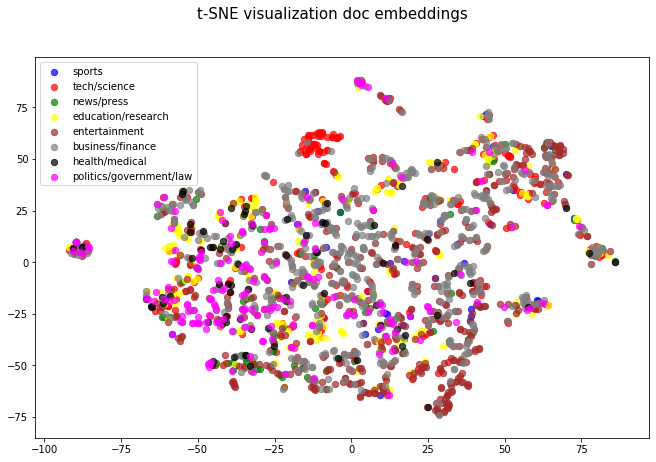

In [12]:
visualize_doc_embeddings(X,y_train)

In [0]:
import csv
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import numpy as np
import pandas as pd
from pprint import pprint

# Get mapping train hosts to labels
with open("train.csv", 'r') as f:
    train_data = f.read().splitlines()
train_map = {}
for row in train_data:
    host, label = row.split(",")
    train_map[host] = label.lower()

# Read embeddings and retrieve corresponding hosts
X_dic = pickle.load(open('train_embeddings.pkl','rb'))
Y_dic = pickle.load(open('test_embeddings.pkl','rb'))
X = []
train_hosts = []
y_train = []
Y = []
test_hosts = []
for file in X_dic:
    X.append(X_dic[file])
    train_hosts.append(file)
    y_train.append(train_map[file])
for file in Y_dic:
    Y.append(Y_dic[file])
    test_hosts.append(file)
X = np.array(X)
Y = np.array(Y)
print("train dimension:", X.shape)
print("test dimension:", Y.shape)

# Grid search for Logistic Regression, with 4-fold CV
penalty = ['l2','l1', none]
C = [0.01,0.1,1.,10,100]
max_iter=[10000]
grid = {'penalty': penalty,
        'C': C,
        'max_iter': max_iter}
pprint(grid)

# Logistic Regression Fit
clf = LogisticRegression()
clf_grid = GridSearchCV(estimator=clf, param_grid=grid, scoring='neg_log_loss',
                        cv = 5, verbose=2, n_jobs = -1)
clf_grid.fit(X, y_train)
print('best CV score:', clf_grid.best_score_)
pprint(clf_grid.best_params_)

# Test Predictions
y_pred = clf_grid.best_estimator_.predict_proba(Y)
with open('results.csv', 'w') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    lst = clf_grid.classes_.tolist()
    lst.insert(0, "Host")
    writer.writerow(lst)
    for i,test_host in enumerate(test_hosts):
        lst = y_pred[i,:].tolist()
        lst.insert(0, test_host)
        writer.writerow(lst)